In [11]:
# TODO: clean imports
import numpy as np
import pandas as pd
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split



from ollama import chat
from ollama import embeddings
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

import os
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

from modules import *

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None



In [12]:
# load parquet files
data_path = Path("../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

##unsafe
# for file_path in list((notebooks_path / data_path).glob("*.parquet")):
#     print(f"Reading {file_path}")
#     # retrieve the name of the file without the extension for all OS
#     data = pd.read_parquet(file_path)
#     # if "Time" in df.columns:
#     #     df["Time"] = pd.to_datetime(df["Time"])
#     data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0].replace("-", "_")] = data

for file_path in (notebooks_path / data_path).glob("set*.parquet"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_parquet(file_path)
    print(f"Reading {file_path} -> {var_name}")


ID_vars = ["PatientID", "Time", "RecordID"]
# stationary variables
stationary_vars = ["Age", "Gender", "Height"] #, "ICUType"]
# dynamic variables
dynamic_vars = set_a.columns.difference(stationary_vars + ID_vars).tolist()


Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a-filled.parquet -> set_a_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b.parquet -> set_b
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a.parquet -> set_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c-filled.parquet -> set_c_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c.parquet -> set_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b-filled.parquet -> set_b_filled


In [13]:
# for key in ["a", "b", "c"]:
#     print(f"Extracting set_{key}") 
#     df = extract_features(globals()[f"set_{key}_filled"])
#     df.to_csv(notebooks_path / data_path / Path(f"features_{key}.csv"))

In [14]:
for file_path in (notebooks_path / data_path).glob("features*.csv"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_csv(file_path)
    print(f"Reading {file_path} -> {var_name}")

Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_a.csv -> features_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_c.csv -> features_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_b.csv -> features_b


          Feature  Importance
86       GCS_last    0.030602
84       GCS_mean    0.020119
66     Urine_mean    0.018542
89      GCS_slope    0.017366
128      BUN_last    0.013003
126      BUN_mean    0.012833
138     HCO3_mean    0.011241
44       WBC_last    0.010143
1         Age_max    0.009277
72     PaCO2_mean    0.008891
131     BUN_slope    0.008636
192  Glucose_mean    0.008606
93         pH_std    0.008586
69      Urine_std    0.008528
30        HR_mean    0.008468
2        Age_last    0.008306
60      FiO2_mean    0.008185
210       Na_mean    0.008067
67      Urine_max    0.007946
143    HCO3_slope    0.007859


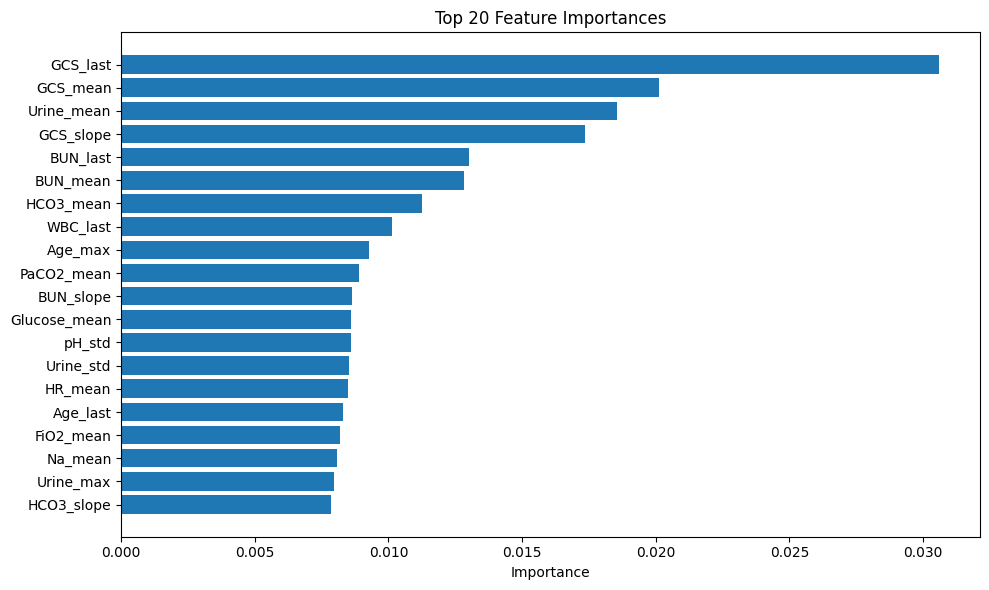

In [15]:
# Train a Random Forest to check feature importance for classification
def split_labels_and_features(df):
    exclude = ["In-hospital_death", "RecordID", "Unnamed", "ICUType"]
    labels = df['In-hospital_death_mean']
    features = df.loc[:, ~df.columns.str.contains("|".join(exclude))].copy()

    return features, labels

## top k features
top_k_features = 20

X_train, y_train = split_labels_and_features(features_a)

# Assuming you've already trained your Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract importances
importances = rf.feature_importances_

# Create a sorted DataFrame
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print top features
print(importance_df.head(top_k_features))

# Optional: plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:top_k_features][::-1], importance_df["Importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [16]:
# Assume df is your test set DataFrame with top features + labels
# !ollama serve
# !ollama list

In [17]:
# MVP
# max_cases = 1
# scoring_bool = True

# prompt, test_cases, outcomes = build_few_shot_prompt(features_a, label_col = "In-hospital_death_mean", scoring = scoring_bool)


# for i, test_case in enumerate(test_cases[:max_cases]):
#     print(f"\n--- Test Case {i+1} ---")
#     prediction = query_llm(prompt, test_case).lower()
#     print(f"Prediction: {prediction}")
#     print(f"Truth: {outcomes[i]}")


Patient Cases:   0%|          | 0/3997 [00:00<?, ?it/s]


📊 Confusion Matrix:


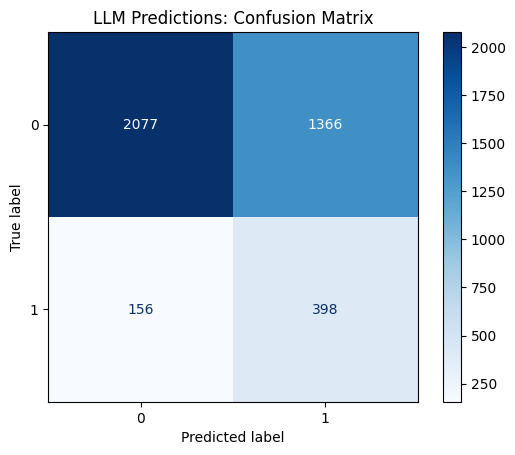

AUROC : 0.3392
AUPRC : 0.1192


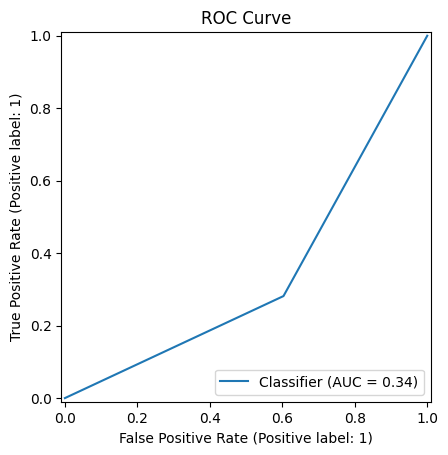

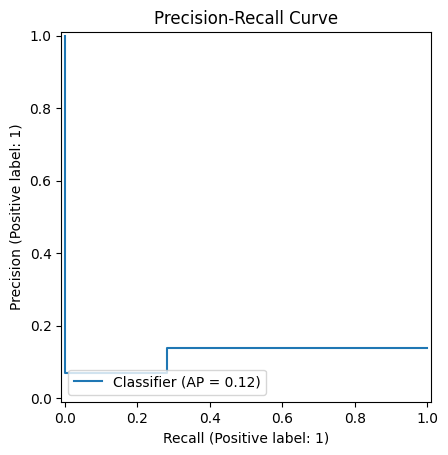

In [19]:
prompt, test_cases, outcomes = build_few_shot_prompt(
    features_a,
    label_col="In-hospital_death_mean",
    scoring=False
)

y_true, y_pred, y_scores = evaluate_llm_predictions(prompt, test_cases, outcomes, model="gemma2:2b", max_cases=3997)


## Q4.2 Embedding Task

In [7]:
def get_patient_embedding(text, model='gemma2:2b'):
    response = embeddings(model=model, prompt=text)
    return response['embedding']

def get_all(prompt, test_cases, model='gemma2:2b'):
    return [get_patient_embedding(f"{prompt}\n\n{t}", model=model) for t in tqdm(test_cases, desc="Generating embeddings")]


######################### Training Data #########################
# prompt, test_cases, outcomes = build_few_shot_prompt(
#     features_a,
#     label_col="In-hospital_death_mean",
#     scoring=False
# )

# embeddings_list = get_all(prompt, test_cases, model='gemma2:2b')

# # Save as DataFrame for probe training
# embedding_df = pd.DataFrame(embeddings_list)

# # Add labels
# embedding_df['label'] = features_a['In-hospital_death_mean'].copy()

# # Save to csv 
# filename = Path(f"embedding_df_Q42_a.csv")
# embedding_df.to_csv(notebooks_path / data_path / filename)

# ######################## Validation Data #########################
# prompt, test_cases, outcomes = build_few_shot_prompt(
#     features_b,
#     label_col="In-hospital_death_mean",
#     scoring=False
# )

# embeddings_list = get_all(prompt, test_cases, model='gemma2:2b')

# # Save as DataFrame for probe training
# embedding_df = pd.DataFrame(embeddings_list)

# # Add labels
# embedding_df['label'] = features_b['In-hospital_death_mean'].copy()

# # Save to csv 
# filename = Path(f"embedding_df_Q42_b.csv")
# embedding_df.to_csv(notebooks_path / data_path / filename)

# ######################## Test Data #########################
# prompt, test_cases, outcomes = build_few_shot_prompt(
#     features_c,
#     label_col="In-hospital_death_mean",
#     scoring=False
# )

# embeddings_list = get_all(prompt, test_cases, model='gemma2:2b')

# # Save as DataFrame for probe training
# embedding_df = pd.DataFrame(embeddings_list)

# # Add labels
# embedding_df['label'] = features_c['In-hospital_death_mean'].copy()

# # Save to csv 
# filename = Path(f"embedding_df_Q42_c.csv")
# embedding_df.to_csv(notebooks_path / data_path / filename)

In [8]:
# load embeddings df

# train
filename = Path(f"embedding_df_Q42_a.csv")
embedding_df_a = pd.read_csv(notebooks_path / data_path / filename)
filename = Path(f"embedding_df_Q42_b.csv")
embedding_df_b = pd.read_csv(notebooks_path / data_path / filename)
filename = Path(f"embedding_df_Q42_c.csv")
embedding_df_c = pd.read_csv(notebooks_path / data_path / filename)
del filename

In [9]:
# Logistic Regression 


# ==== 1. Define Model ====
class MortalityPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.layer(x).squeeze(-1)


In [10]:
# ==== 2. Training & Evaluation Logic ====
def evaluate(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_logits.append(probs.cpu())
            all_labels.append(yb.cpu())
    y_true = torch.cat(all_labels).numpy()
    y_score = torch.cat(all_logits).numpy()
    
    # print("y_true:", np.unique(y_true))
    # print("y_score shape:", y_score.shape, "dtype:", y_score.dtype)

    return {
        'AUROC': roc_auc_score(y_true, y_score),
        'AUPRC': average_precision_score(y_true, y_score)
    }
    
def train_model(X_train, y_train, X_val, y_val, X_test, y_test, model, 
                epochs=20, batch_size=32, lr=1e-3):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Wrap tensors in datasets
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    test_ds = TensorDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Define model
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        for xb, yb in train_loader:
            # print(xb.shape)
            xb, yb = xb.to(device), yb.to(device).float()
            logits = model(xb)
            # print(logits.device)
            # return
            # print(logits.shape)
            # print(yb.shape)
            # return
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_metrics = evaluate(model, val_loader, device)
        print(f"[Epoch {epoch+1}] Val AUROC: {val_metrics['AUROC']:.4f}, AUPRC: {val_metrics['AUPRC']:.4f}")
        # return

    print("✅ Finished training. Evaluating on test set...")
    test_metrics = evaluate(model, test_loader, device)
    print(f"Test AUROC: {test_metrics['AUROC']:.4f}, AUPRC: {test_metrics['AUPRC']:.4f}")

    return model, test_metrics

from sklearn.model_selection import KFold, train_test_split

def run_cross_val(embedding_df_a, embedding_df_b, embedding_df_c,
                  model_class, epochs=20, batch_size=32, lr=1e-3,
                  k_folds=None, split=0.2):

    # === 1. Stack A + B ===
    full_df = pd.concat([embedding_df_a, embedding_df_b], axis=0).reset_index(drop=True)

    X = torch.tensor(full_df.iloc[:, :-1].values).float()
    y = torch.tensor(full_df["label"].values).float()

    # === 2. Prepare test set (C stays untouched) ===
    X_test = torch.tensor(embedding_df_c.iloc[:, :-1].values).float()
    y_test = torch.tensor(embedding_df_c["label"].values).float()

    # === 3. Run K-Fold or Train/Val Split ===
    fold_metrics = []

    if k_folds:
        print(f"Running {k_folds}-Fold Cross-Validation...\n")
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"\n=== Fold {fold_idx+1}/{k_folds} ===")
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val     = X[val_idx], y[val_idx]

            model = model_class(input_dim=X.shape[-1])
            _, metrics = train_model(X_train, y_train, X_val, y_val, X_test, y_test,
                                     model=model, epochs=epochs, batch_size=batch_size, lr=lr)
            fold_metrics.append(metrics)

    else:
        print(f"Running single train/val split (val ratio = {split})...")
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split, random_state=42, stratify=y)

        model = model_class(input_dim=X.shape[-1])
        _, metrics = train_model(X_train, y_train, X_val, y_val, X_test, y_test,
                                 model=model, epochs=epochs, batch_size=batch_size, lr=lr)
        fold_metrics.append(metrics)

    return fold_metrics


y_train = torch.tensor(embedding_df_a["label"]).float()
X_train = torch.tensor(embedding_df_a.iloc[:, :-1].values).float()
y_val = torch.tensor(embedding_df_b["label"]).float()
X_val = torch.tensor(embedding_df_b.iloc[:, :-1].values).float()
y_test = torch.tensor(embedding_df_c["label"]).float()
X_test = torch.tensor(embedding_df_c.iloc[:, :-1].values).float()
model = MortalityPredictor(input_dim = X_train.shape[-1])

# metrics = run_cross_val(
#     embedding_df_a,
#     embedding_df_b,
#     embedding_df_c,
#     model_class=MortalityPredictor,
#     k_folds=5,              # or None
#     split=0.2,              # used only if k_folds is None
#     epochs=20,
#     batch_size=32,
#     lr=1e-3
# )

# # Optional: print aggregated results
# for i, m in enumerate(metrics):
#     print(f"Fold {i+1} → AUROC: {m['AUROC']:.4f}, AUPRC: {m['AUPRC']:.4f}")

# # Mean performance across folds
# mean_auroc = np.mean([m['AUROC'] for m in metrics])
# mean_auprc = np.mean([m['AUPRC'] for m in metrics])
print(f"\nAverage AUROC: {mean_auroc:.4f}, AUPRC: {mean_auprc:.4f}")

model, test_metrics = train_model(X_train, y_train, X_val, y_val, X_test, y_test, model, epochs=20, batch_size=32, lr=1e-3)

NameError: name 'mean_auroc' is not defined